# Energy optimization summary

Saved Figure_Energy_Optimization_Summary.png at 600 DPI


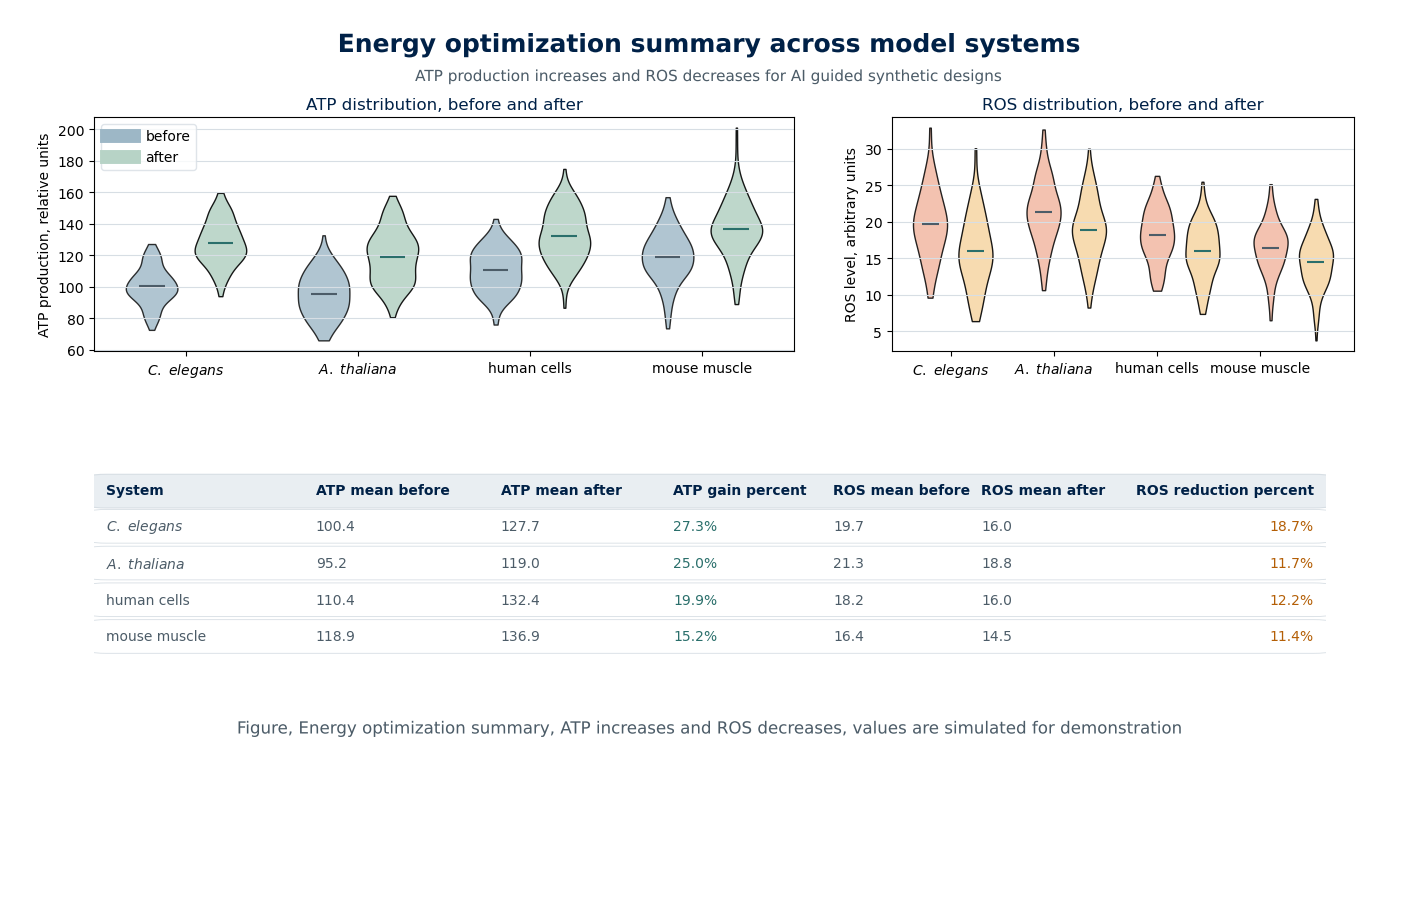

In [9]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import matplotlib.patheffects as pe

# style and palette
mpl.rcParams["figure.figsize"] = (14, 9)
mpl.rcParams["savefig.dpi"] = 600
mpl.rcParams["font.family"] = "DejaVu Sans"
mpl.rcParams["font.size"] = 10
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["figure.facecolor"] = "white"

OX_BLUE = "#002147"
OX_TEAL = "#2A6F6B"
OX_SLATE = "#4C5C68"
OX_EDGE = "#D7DEE4"
OX_MIST = "#E9EEF2"

# helpers, restored

def add_card(ax, xy, wh, face="white", edge=OX_EDGE, rounding=10, lw=0.8, z=1):
    x, y = xy
    w, h = wh
    box = FancyBboxPatch(
        (x, y), w, h,
        boxstyle=f"round,pad=0.012,rounding_size={rounding}",
        linewidth=lw, edgecolor=edge, facecolor=face, zorder=z
    )
    ax.add_patch(box)
    return box

def add_text(ax, x, y, s, size=11, weight="regular", color=OX_BLUE, ha="center", va="center"):
    t = ax.text(x, y, s, fontsize=size, fontweight=weight, color=color, ha=ha, va=va)
    # subtle white stroke improves readability over light backgrounds
    t.set_path_effects([pe.withStroke(linewidth=2, foreground="white", alpha=0.92)])
    return t

# simulate summary data
np.random.seed(7)

systems = ["$\\it{C.\\ elegans}$", "$\\it{A.\\ thaliana}$", "human cells", "mouse muscle"]
n_per = 120

def sim_pair(mu_base, sd_base, mu_delta, sd_delta, floor=0):
    base = np.clip(np.random.normal(mu_base, sd_base, n_per), floor, None)
    after = np.clip(base + np.random.normal(mu_delta, sd_delta, n_per), floor, None)
    return base, after

# ATP production, higher is better, units are scaled relative
atp_params = {
    "C":  (100, 12,  28, 8),
    "A":  (95,  15,  24, 9),
    "H":  (110, 14, 22, 7),
    "M":  (120, 16, 18, 7),
}

# ROS level, lower is better, arbitrary units
ros_params = {
    "C":  (20,  4.5, -3.5, 1.2),
    "A":  (22,  5.0, -2.6, 1.1),
    "H":  (18,  4.0, -2.2, 1.0),
    "M":  (17,  3.8, -1.8, 0.9),
}

# map for label order
order = ["C", "A", "H", "M"]

# build dataframe
records = []
for key, label in zip(order, systems):
    mb, ma = sim_pair(*atp_params[key])
    rb, ra = sim_pair(*ros_params[key])
    for b in mb:
        records.append({"System": label, "Metric": "ATP, before", "Value": b})
    for a in ma:
        records.append({"System": label, "Metric": "ATP, after", "Value": a})
    for b in rb:
        records.append({"System": label, "Metric": "ROS, before", "Value": b})
    for a in ra:
        records.append({"System": label, "Metric": "ROS, after", "Value": a})

df = pd.DataFrame(records)

# compute summary table
summary_rows = []
for label in systems:
    atp_b = df[(df.System == label) & (df.Metric == "ATP, before")]["Value"].values
    atp_a = df[(df.System == label) & (df.Metric == "ATP, after")]["Value"].values
    ros_b = df[(df.System == label) & (df.Metric == "ROS, before")]["Value"].values
    ros_a = df[(df.System == label) & (df.Metric == "ROS, after")]["Value"].values

    atp_gain = 100.0 * (np.mean(atp_a) - np.mean(atp_b)) / np.mean(atp_b)
    ros_drop = 100.0 * (np.mean(ros_b) - np.mean(ros_a)) / np.mean(ros_b)

    summary_rows.append({
        "System": label,
        "ATP mean before": np.mean(atp_b),
        "ATP mean after":  np.mean(atp_a),
        "ATP gain percent": atp_gain,
        "ROS mean before": np.mean(ros_b),
        "ROS mean after":  np.mean(ros_a),
        "ROS reduction percent": ros_drop
    })

summary = pd.DataFrame(summary_rows)

# canvas
fig = plt.figure()
root = fig.add_axes([0, 0, 1, 1])
root.set_xlim(0, 100)
root.set_ylim(0, 100)
root.axis("off")

# title
add_text(root, 50, 96, "Energy optimization summary across model systems", size=18, weight="bold", color=OX_BLUE)
add_text(root, 50, 92.5, "ATP production increases and ROS decreases for AI guided synthetic designs", size=11, color=OX_SLATE)

# optional cards if you want section frames, uncomment to use
# add_card(root, (4, 60), (57, 28), face="white")
# add_card(root, (62, 60), (34, 28), face="white")
# add_card(root, (4, 14), (92, 40), face="white")

# ATP violin plot, left
ax_atp = fig.add_axes([0.06, 0.62, 0.50, 0.26])
ax_atp.set_facecolor("white")
ax_atp.grid(color=OX_EDGE, linewidth=0.8, axis="y")

labels = systems
positions_before = np.arange(len(labels)) * 2.0
positions_after  = positions_before + 0.8

atp_data_before = [df[(df.System == lab) & (df.Metric == "ATP, before")]["Value"].values for lab in labels]
atp_data_after  = [df[(df.System == lab) & (df.Metric == "ATP, after")]["Value"].values for lab in labels]

parts_b = ax_atp.violinplot(atp_data_before, positions=positions_before, widths=0.6, showmeans=True, showextrema=False)
parts_a = ax_atp.violinplot(atp_data_after,  positions=positions_after,  widths=0.6, showmeans=True, showextrema=False)

for pc in parts_b["bodies"]:
    pc.set_facecolor("#9DB7C6")
    pc.set_edgecolor("black")
    pc.set_alpha(0.8)
parts_b["cmeans"].set_color(OX_SLATE)

for pc in parts_a["bodies"]:
    pc.set_facecolor("#B7D3C6")
    pc.set_edgecolor("black")
    pc.set_alpha(0.9)
parts_a["cmeans"].set_color(OX_TEAL)

ax_atp.set_xticks((positions_before + positions_after) / 2.0)
ax_atp.set_xticklabels(labels)
ax_atp.set_ylabel("ATP production, relative units")
ax_atp.set_title("ATP distribution, before and after", fontsize=12, color=OX_BLUE)

from matplotlib.lines import Line2D
legend_items = [
    Line2D([0], [0], color="#9DB7C6", lw=10, label="before"),
    Line2D([0], [0], color="#B7D3C6", lw=10, label="after")
]
ax_atp.legend(handles=legend_items, frameon=True, facecolor="white", edgecolor=OX_EDGE, loc="upper left")

# ROS violin plot, right
ax_ros = fig.add_axes([0.63, 0.62, 0.33, 0.26])
ax_ros.set_facecolor("white")
ax_ros.grid(color=OX_EDGE, linewidth=0.8, axis="y")

ros_data_before = [df[(df.System == lab) & (df.Metric == "ROS, before")]["Value"].values for lab in labels]
ros_data_after  = [df[(df.System == lab) & (df.Metric == "ROS, after")]["Value"].values for lab in labels]

pos_b = np.arange(len(labels)) * 2.0
pos_a = pos_b + 0.8

parts_rb = ax_ros.violinplot(ros_data_before, positions=pos_b, widths=0.6, showmeans=True, showextrema=False)
parts_ra = ax_ros.violinplot(ros_data_after,  positions=pos_a, widths=0.6, showmeans=True, showextrema=False)

for pc in parts_rb["bodies"]:
    pc.set_facecolor("#F2B8A2")
    pc.set_edgecolor("black")
    pc.set_alpha(0.85)
parts_rb["cmeans"].set_color(OX_SLATE)

for pc in parts_ra["bodies"]:
    pc.set_facecolor("#F7D8A8")
    pc.set_edgecolor("black")
    pc.set_alpha(0.9)
parts_ra["cmeans"].set_color(OX_TEAL)

ax_ros.set_xticks((pos_b + pos_a) / 2.2)
ax_ros.set_xticklabels(labels, rotation=0)
ax_ros.set_ylabel("ROS level, arbitrary units")
ax_ros.set_title("ROS distribution, before and after", fontsize=12, color=OX_BLUE)

# summary table, bottom
ax_tbl = fig.add_axes([0.06, 0.16, 0.88, 0.34])
ax_tbl.axis("off")

tbl = summary.copy()
tbl["ATP mean before"] = tbl["ATP mean before"].map(lambda x: f"{x:,.1f}")
tbl["ATP mean after"]  = tbl["ATP mean after"].map(lambda x: f"{x:,.1f}")
tbl["ATP gain percent"] = tbl["ATP gain percent"].map(lambda x: f"{x:,.1f}")
tbl["ROS mean before"] = tbl["ROS mean before"].map(lambda x: f"{x:,.1f}")
tbl["ROS mean after"]  = tbl["ROS mean after"].map(lambda x: f"{x:,.1f}")
tbl["ROS reduction percent"] = tbl["ROS reduction percent"].map(lambda x: f"{x:,.1f}")

row_y = 0.90
line_h = 0.12

# header band
ax_tbl.add_patch(FancyBboxPatch((0.00, row_y - 0.05), 1.00, 0.09,
                                boxstyle="round,pad=0.01,rounding_size=0.02",
                                facecolor=OX_MIST, edgecolor=OX_EDGE, linewidth=0.8))
ax_tbl.text(0.01, row_y, "System", color=OX_BLUE, weight="bold", va="center")
ax_tbl.text(0.18, row_y, "ATP mean before", color=OX_BLUE, weight="bold", va="center")
ax_tbl.text(0.33, row_y, "ATP mean after", color=OX_BLUE, weight="bold", va="center")
ax_tbl.text(0.47, row_y, "ATP gain percent", color=OX_BLUE, weight="bold", va="center")
ax_tbl.text(0.60, row_y, "ROS mean before", color=OX_BLUE, weight="bold", va="center")
ax_tbl.text(0.72, row_y, "ROS mean after", color=OX_BLUE, weight="bold", va="center")
ax_tbl.text(0.99, row_y, "ROS reduction percent", color=OX_BLUE, weight="bold", va="center", ha="right")

# data rows
for _, r in tbl.iterrows():
    row_y -= line_h
    ax_tbl.add_patch(FancyBboxPatch((0.00, row_y - 0.045), 1.00, 0.09,
                                    boxstyle="round,pad=0.01,rounding_size=0.02",
                                    facecolor="white", edgecolor=OX_EDGE, linewidth=0.6))
    ax_tbl.text(0.01, row_y, f"{r['System']}", color=OX_SLATE, va="center")
    ax_tbl.text(0.18, row_y, f"{r['ATP mean before']}", color=OX_SLATE, va="center")
    ax_tbl.text(0.33, row_y, f"{r['ATP mean after']}", color=OX_SLATE, va="center")
    ax_tbl.text(0.47, row_y, f"{r['ATP gain percent']}%", color=OX_TEAL, va="center")
    ax_tbl.text(0.60, row_y, f"{r['ROS mean before']}", color=OX_SLATE, va="center")
    ax_tbl.text(0.72, row_y, f"{r['ROS mean after']}", color=OX_SLATE, va="center")
    ax_tbl.text(0.99, row_y, f"{r['ROS reduction percent']}%", color="#B45F06", va="center", ha="right")

# footer
add_text(root, 50, 20, "Figure, Energy optimization summary, ATP increases and ROS decreases, values are simulated for demonstration", size=12, color=OX_SLATE)

# save
plt.savefig("Figure_Energy_Optimization_Summary.png", dpi=600, bbox_inches="tight")
print("Saved Figure_Energy_Optimization_Summary.png at 600 DPI")
plt.show()

# MITOFOMER INTEGRATIVE DASHBOARD

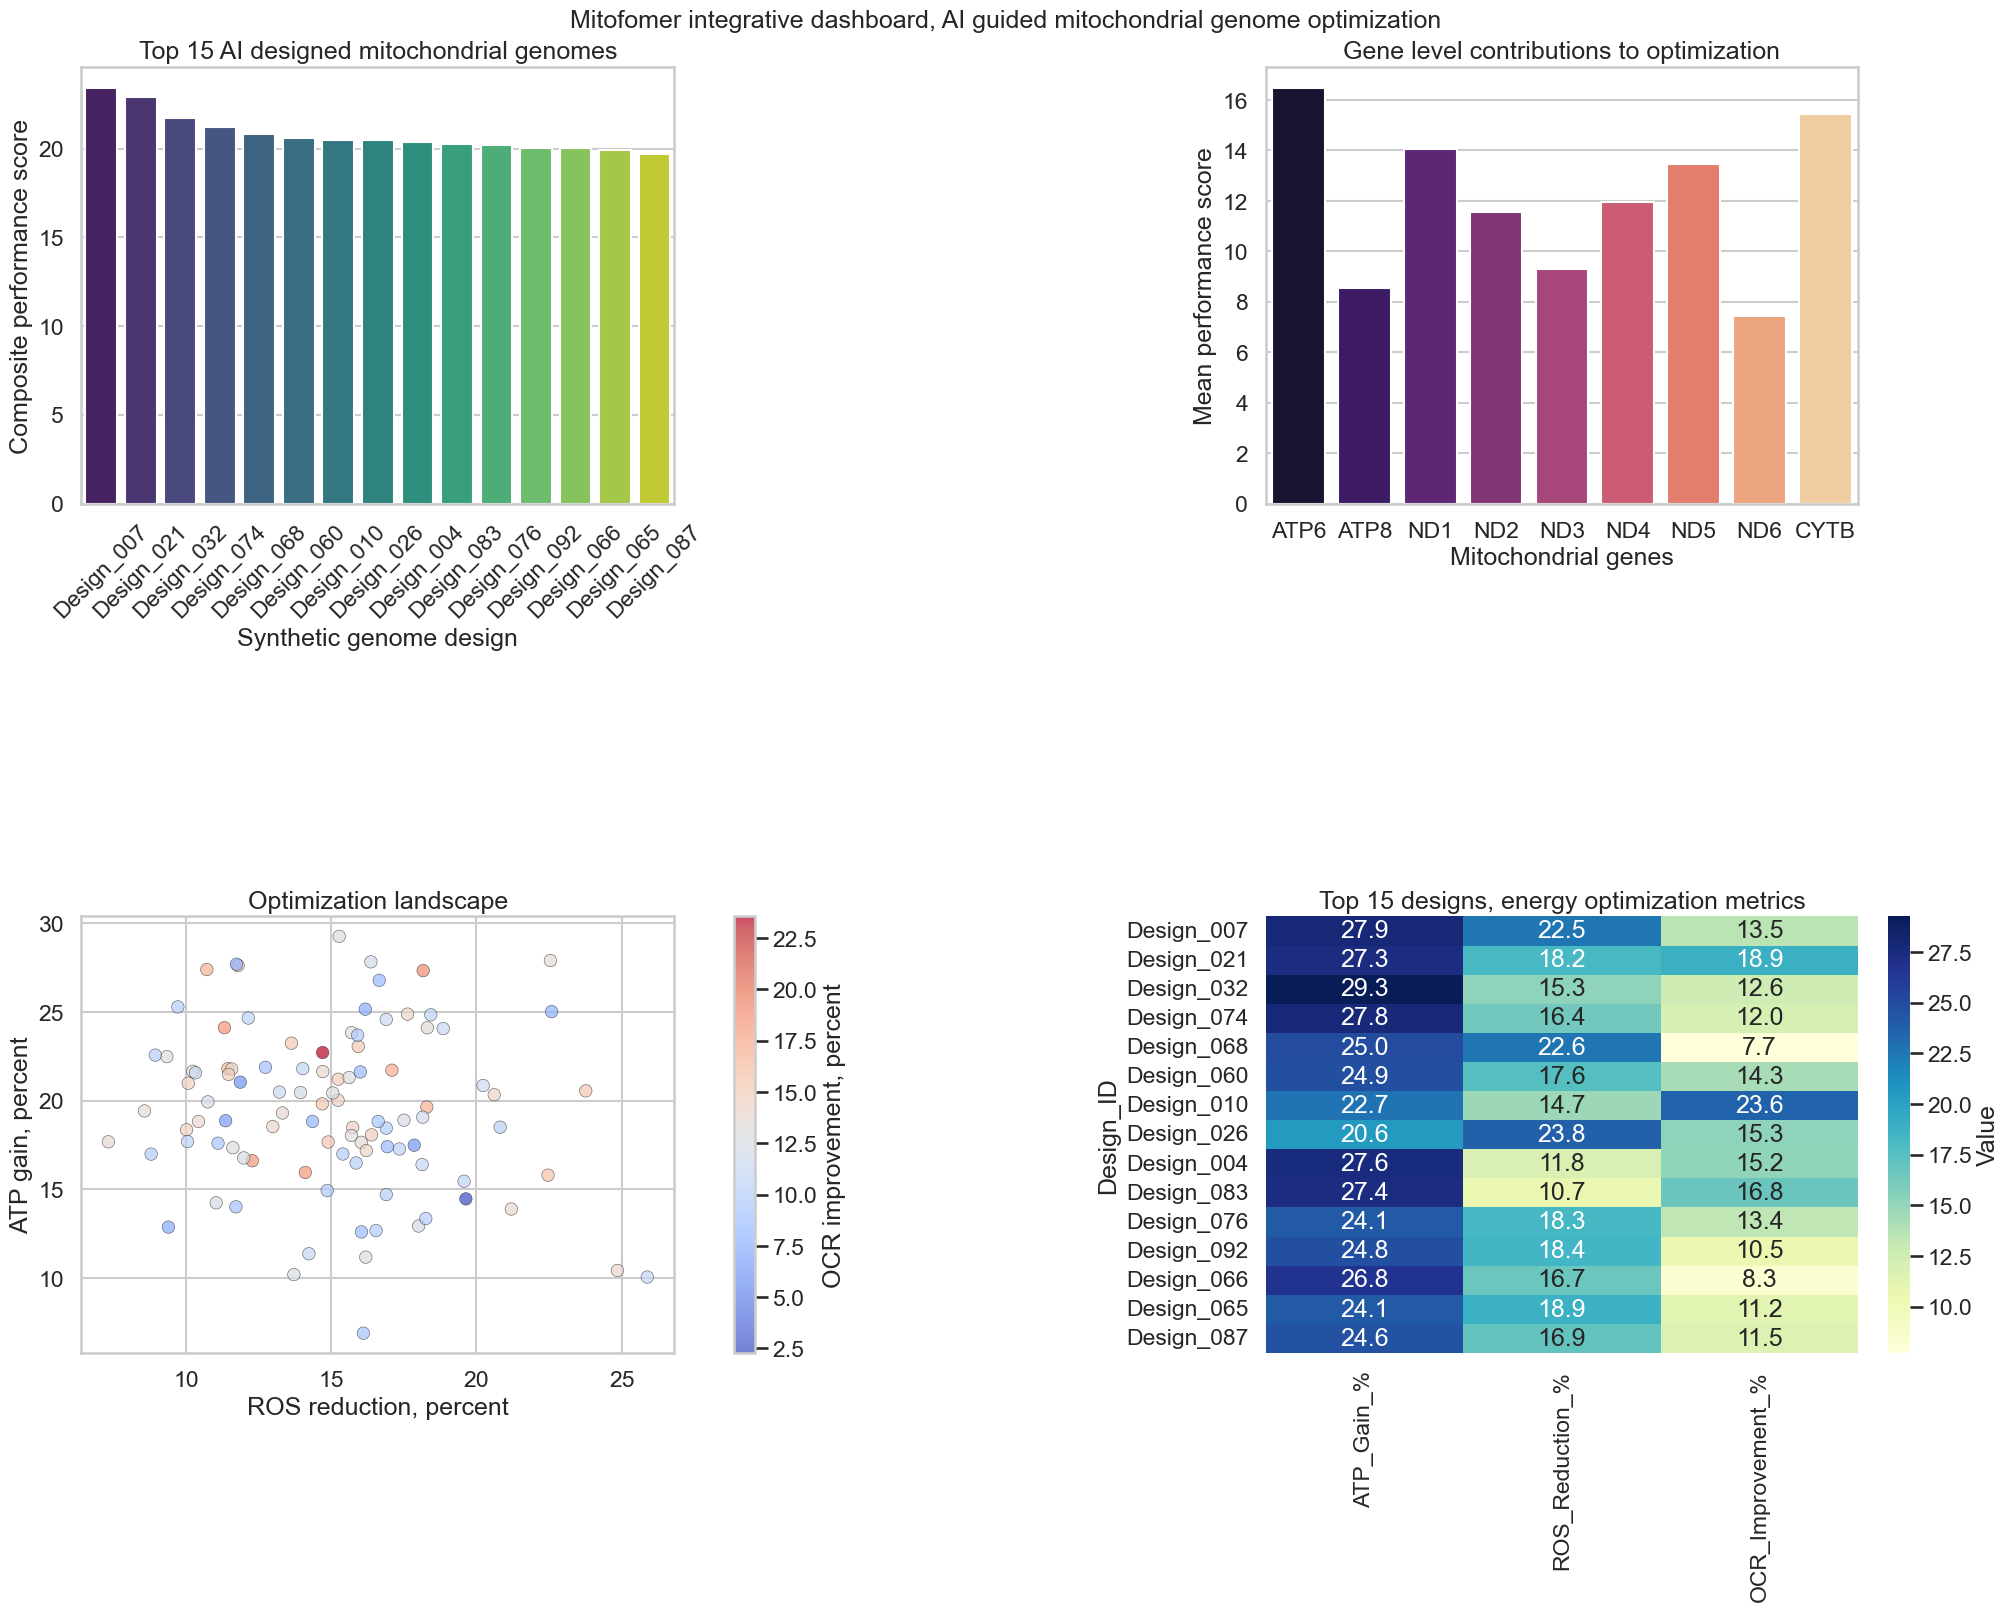

Dashboard complete
Top genome designs saved as Mitofomer_Top_Genome_Designs.csv
Gene level contributions saved as Mitofomer_Gene_Contributions.csv


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visuals
sns.set(style="whitegrid", context="talk")
np.random.seed(42)

# 1. SIMULATE TOP RANKED GENOME DESIGNS

num_designs = 100
top_designs = pd.DataFrame({
    "Design_ID": [f"Design_{i+1:03d}" for i in range(num_designs)],
    "ATP_Gain_%": np.random.normal(20, 5, num_designs),
    "ROS_Reduction_%": np.random.normal(15, 4, num_designs),
    "OCR_Improvement_%": np.random.normal(12, 3, num_designs),
})

top_designs["Score"] = (
    0.5 * top_designs["ATP_Gain_%"] +
    0.3 * top_designs["ROS_Reduction_%"] +
    0.2 * top_designs["OCR_Improvement_%"]
)
top_designs = top_designs.sort_values(by="Score", ascending=False).reset_index(drop=True)

# 2. GENE LEVEL CONTRIBUTIONS
genes = ["ATP6", "ATP8", "ND1", "ND2", "ND3", "ND4", "ND5", "ND6", "CYTB"]

gene_contributions = pd.DataFrame({
    "Gene": np.repeat(genes, 50),
    "ATP_Gain_%": np.concatenate([
        np.random.normal(15, 3, 50), np.random.normal(7, 2, 50),
        np.random.normal(12, 3, 50), np.random.normal(10, 3, 50),
        np.random.normal(8, 2, 50), np.random.normal(9, 3, 50),
        np.random.normal(11, 3, 50), np.random.normal(6, 2, 50),
        np.random.normal(13, 3, 50),
    ]),
    "ROS_Reduction_%": np.concatenate([
        np.random.normal(18, 4, 50), np.random.normal(10, 3, 50),
        np.random.normal(16, 4, 50), np.random.normal(14, 3, 50),
        np.random.normal(12, 3, 50), np.random.normal(15, 4, 50),
        np.random.normal(17, 4, 50), np.random.normal(9, 2, 50),
        np.random.normal(20, 5, 50),
    ])
})
gene_contributions["Performance_Score"] = (
    0.6 * gene_contributions["ATP_Gain_%"] +
    0.4 * gene_contributions["ROS_Reduction_%"]
)

# 3. BUILD DASHBOARD, use constrained layout for clean spacing
fig = plt.figure(figsize=(20, 16), constrained_layout=True)
grid = fig.add_gridspec(2, 2, wspace=0.25, hspace=0.3)

# A. Top genome designs
ax1 = fig.add_subplot(grid[0, 0])
td15 = top_designs.head(15).copy()
# Use hue equal to x, hide legend, set palette through hue mapping
sns.barplot(
    data=td15,
    x="Design_ID", y="Score",
    hue="Design_ID", palette="viridis",
    legend=False, errorbar=None, ax=ax1
)
ax1.set_title("Top 15 AI designed mitochondrial genomes")
ax1.set_xlabel("Synthetic genome design")
ax1.set_ylabel("Composite performance score")
ax1.tick_params(axis="x", rotation=45)

# B. Gene contributions
ax2 = fig.add_subplot(grid[0, 1])
sns.barplot(
    data=gene_contributions,
    x="Gene", y="Performance_Score",
    hue="Gene", palette="magma",
    estimator=np.mean, errorbar=None, legend=False, ax=ax2
)
ax2.set_title("Gene level contributions to optimization")
ax2.set_xlabel("Mitochondrial genes")
ax2.set_ylabel("Mean performance score")

# C. Optimization landscape, ATP versus ROS, color by OCR
ax3 = fig.add_subplot(grid[1, 0])
sc = ax3.scatter(
    top_designs["ROS_Reduction_%"],
    top_designs["ATP_Gain_%"],
    c=top_designs["OCR_Improvement_%"],
    cmap="coolwarm", alpha=0.7, edgecolors="k", linewidths=0.4
)
cbar = fig.colorbar(sc, ax=ax3)
cbar.set_label("OCR improvement, percent")
ax3.set_title("Optimization landscape")
ax3.set_xlabel("ROS reduction, percent")
ax3.set_ylabel("ATP gain, percent")

# D. Heatmap of top designs
ax4 = fig.add_subplot(grid[1, 1])
heatmap_data = td15.set_index("Design_ID")[["ATP_Gain_%", "ROS_Reduction_%", "OCR_Improvement_%"]]
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", ax=ax4, cbar_kws={"label": "Value"})
ax4.set_title("Top 15 designs, energy optimization metrics")

fig.suptitle("Mitofomer integrative dashboard, AI guided mitochondrial genome optimization", fontsize=18)
plt.show()

# 4. EXPORT DASHBOARD DATA
top_designs.to_csv("Mitofomer_Top_Genome_Designs.csv", index=False)
gene_contributions.to_csv("Mitofomer_Gene_Contributions.csv", index=False)

print("Dashboard complete")
print("Top genome designs saved as Mitofomer_Top_Genome_Designs.csv")
print("Gene level contributions saved as Mitofomer_Gene_Contributions.csv")